# (1.1) Load Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize

In [2]:
from collections import namedtuple
from collections import defaultdict

np.set_printoptions(threshold=np.inf)
Dataset = namedtuple('Dataset', 'name, train, test')
Model = namedtuple('Model', 'type, name, dimension, corpus, model')

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]


datasets = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

feature_categories = []

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

# (1.2) Load Embedding Models

In [4]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'

glove_defs = [#Model('glove', 'glove.42B.300d.txt', 300, 'cc42B', None),  
              #Model('glove', 'glove.840B.300d.txt', 300, 'cc840B', None), 
              Model('glove', 'glove.6B.50d.txt', 50, 'wikipedia+gigaword5', None), 
              #Model('glove', 'glove.6B.100d.txt',100, 'wikipedia+gigaword5', None),
              #Model('glove', 'glove.6B.200d.txt', 200, 'wikipedia+gigaword5', None), 
              #Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None),
              #Model('glove', 'glove.twitter.27B.25d.txt', 25, 'twitter', None)]
              Model('glove', 'glove.twitter.27B.50d.txt', 50, 'twitter', None)] 
              #Model('glove', 'glove.twitter.27B.100d.txt', 100, 'twitter', None), 
              #Model('glove', 'glove.twitter.27B.200d.txt', 200, 'twitter', None)]

glove_models = []
for model in glove_defs:
    glove_file = datapath(MAIN_PATH + model.name)
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
    glove_models.append(Model(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))
    
print(glove_models)

C:\Users\Studio\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


load model : glove.6B.50d.txt
load model : glove.twitter.27B.50d.txt
[Model(type='glove', name='glove.6B.50d.txt', dimension=50, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000000FF9AD07358>), Model(type='glove', name='glove.twitter.27B.50d.txt', dimension=50, corpus='twitter', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000000FFA833D828>)]


In [5]:
models = []
models.extend(glove_models)

# (2.1) Preprocessing
Here we present all the code to preprocess the data stored in a dataframe into a proper representation that can be used in sequence tagging models.

In [113]:
from nltk import word_tokenize
from functools import lru_cache
from utils import penn_to_wn
import re
import unicodedata
import sys
from collections import Counter
from ngram_representation import missing_strat_random
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def all_tokens_with_index(context):
    '''
    Receives a sentence denoted by context and applies tokenization
    on the input. Each token is annotated with its word index starting
    from 1 and the corresponding start and end character positions of 
    the word. Also applies some strategies to handle unproper formated
    input sentence string such as removing additional whitespaces and 
    quotation marks that otherwise change the actual character start
    and end positions. All results are cached in case it has to be computed
    multiple times for the same sentence.
    '''
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    return [val for val in targets if val[0] != '"']

def build_vocabulary(sentences, embedding, dimension, 
                     missing='unique', provided = ['s_target', 'e_target']):
    '''
    Based on a list of sentences which are themselve represented
    as a list of words, constructs a vocabulary of the words contained
    and assigns unique indicies to the words. In particular, it returns 
    a map of indices to their words, a map of words to their indices
    and based on the provided embedding model an embedding matrix
    for the constructed vocabulary. For missing vocabulary, it 
    constructs a random embedding and a proper index is missing parameter
    is set to 'unique', otherwise if it is set to 'equal' it creates
    a random embedding for one special UNK embedding and neglects missing
    vocabulary in the built index. All tokens in the 'provided' list,
    receive under 'equal' mode still individual random embeddings.
    '''
    if missing not in ['unique', 'equal']:
        raise ValueError("Parameter missing must be either 'equal' or 'unique'")
    all_words = [word for sentence in sentences for word in sentence]
    print('# Words : {}'.format(len(all_words)))
    counter = Counter(all_words)
    index = 1
    word2index = {}
    for (word, count) in counter.most_common():
        if (missing=='unique' or word in embedding.vocab):
            word2index[word] = index
            index += 1
    word2index['_pad_'] = 0
    if missing == 'equal':
        word2index['_unk_'] = len(word2index)
        for token in provided:
            word2index[token] = len(word2index)
    index2word = {index : word for word, index in word2index.items()}
    vocab_size = len(word2index)
    print('# Vocab : {}'.format(vocab_size))
    embedding_matrix = np.zeros(((vocab_size), dimension))
    embedding_matrix[0] = missing_strat_random('_pad_', dimension)
    missing_embed_words = []
    for word, index in word2index.items():
        if word in embedding.vocab:
            embedding_matrix[index] = embedding[word]
        else:
            embedding_matrix[index] = missing_strat_random(word, dimension)
            missing_embed_words.append(word)
    missing_embed_count = len(missing_embed_words)
    print('# Words missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    return word2index, index2word, embedding_matrix


def build_char_vocabulary(sentences, embedding, dimension, 
                          missing='unique', provided = ['_']):
    '''
    Based on a list of sentences which are themselve represented
    as a list of words, constructs a character vocabulary and provides
    a mapping of unique indices to the found characters, a mapping of
    the characters to their indicies and a character embedding matrix
    where the i-th row represents the character embedding of the character
    with index i. This is based on a provided character embedding, represented
    as a dictionary. Provided tokens will be added as a single char to
    the vocabulary.
    '''
    if missing not in ['unique', 'equal']:
        raise ValueError("Parameter missing must be either 'equal' or 'unique'")
    all_chars = [char for sentence in sentences 
                 for word in sentence for char in word]
    all_chars.extend(provided)
    print('# Chars : {}'.format(len(all_chars)))
    counter = Counter(all_chars)
    index = 1
    char2index = {}
    for (char, count) in counter.most_common():
        if (missing=='unique' or char in embedding.keys()):
            char2index[char] = index
            index += 1
    char2index['_pad_'] = 0
    if missing == 'equal':
        char2index['_unk_'] = len(char2index)
    index2char = {index : char for char, index in char2index.items()}
    vocab_size = len(char2index)
    print('# Vocab (chars) : {}'.format(vocab_size))
    embedding_matrix = np.zeros(((vocab_size), dimension))
    embedding_matrix[0] = missing_strat_random('_pad_', dimension)
    missing_embed_chars = []
    for char, index in char2index.items():
        if char in embedding.keys():
            embedding_matrix[index] = embedding[char]
        else:
            embedding_matrix[index] = missing_strat_random(char, dimension)
            missing_embed_chars.append(char)
    missing_embed_count = len(missing_embed_chars)
    print('# Chars missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    return char2index, index2char, embedding_matrix


def compute_character_embeddings(embedding):
    '''
    Computes a character embedding as a dictionary of word to its
    embedding based on a gensim word embedding. For each character,
    averages the word embeddings containing the character as an
    approximation to character-level embeddings.
    '''
    chars = {}
    for word, vocab in embedding.vocab.items():
        vector = embedding[word]
        for char in word:
            if ord(char)<128:
                if char in chars:
                    chars[char] = (chars[char][0]+vector, 
                                   chars[char][1]+1)
                else:
                    chars[char] = (vector, 1)
    for char, (vector, num) in chars.items():
        chars[char] = np.round(vector/num, 6).tolist()
    return chars

def forward_transformation_v1(dataframe, lowercase = True, filter_punc = True, filtering = "a132"):
    '''
    Transforms the provided dataframe rows into a representation
    to be used in a sequence classifier. For each sentence in the
    dataset, returns the sentence id, the sentence as a list of 
    words based on tokenization, the binary label for each word, 
    the probability label for each word and a list of (start, end)
    tuples representing the start and end positions of the words 
    in the sentence word list. This can be used to map back the
    predictions later. This function should be used if classification
    is done on word level.
    '''
    grouped = dataframe.groupby('sentence').apply(lambda row : 
                        {'sent_id' : list(set(row['sent_id']))[0],
                         'sentence' : list(set(row['sentence']))[0], 
                         'tags': [tag for tag in zip(row['target'], 
                            row['start'], row['end'], row['binary'], row['prob'])]})
    sentence_ids = []
    sentences = []
    binaries = []
    probabilities = []
    start_ends = []
    for vals in grouped:
        sent_id = vals['sent_id']
        sentence = vals['sentence']
        tags = vals['tags']
        tags_without_labels = [(word, start, end) for word, start, end, binary, prob in tags]
        all_tokens = all_tokens_with_index(sentence)
        sent_repr = [(word, start, end, tags[tags_without_labels.index((word, start, end))][3],
                     tags[tags_without_labels.index((word, start, end))][4])
           if (word, start, end) in tags_without_labels 
          else (word, start, end, 0, 0.0) for word, index, start, end in all_tokens]
        if lowercase:
            sent_repr = [(word.lower(), start, end, binary, prob) 
                         for word, start, end, binary, prob in sent_repr]
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentence_ids.append(sent_id)
        sentences.append([vals[0] for vals in sent_repr])
        binaries.append([vals[3] for vals in sent_repr])
        probabilities.append([vals[4] for vals in sent_repr])
        start_ends.append([(vals[1], vals[2]) for vals in sent_repr])
    return sentence_ids, sentences, start_ends, binaries, probabilities


def forward_transformation_v2(dataframe, start_tag = 's_target', end_tag = 'e_target',
                                   lowercase = True, filter_punc = True, filtering = "a132"):
    '''
    Transforms the provided dataframe rows into a representation
    to be used in a sequence classifier. Here, each row in the dataframe
    is transformed into one instance to classify and each target in a 
    sentence is tagged by surrounding it with the provided start and
    end tag. Hence, the whole sequence is classified at once. Returns
    the transformed sentences (one for each row in the dataframe), the
    corresponding binary and probabilitiy label.
    '''
    sentences = []
    binaries = []
    probabilities = []
    for index, row in dataframe.iterrows():
        sentence = row['sentence']
        start = row['start']
        end = row['end']
        sentence = sentence[:start] + start_tag + ' ' + sentence[start:end] + \
                             ' ' + end_tag + sentence[end:]
        if lowercase:
            sentence = sentence.lower()
        sent_repr = all_tokens_with_index(sentence)
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentences.append([word for word, index, start, end in sent_repr])
        binaries.append(row['binary'])
        probabilities.append(row['prob'])
    return sentences, binaries, probabilities


def merge_train_test_dataset(dataset):
    '''
    Computes the training and test set size as (1) the
    number of rows and (2) the number of unique sentences
    contained. Merges the training and test set and
    computes the same values for the merged dataframe.
    This can be used before creating the vocabulary,
    to also not miss vocabulary contained solely in the
    test set. Before training, the dataset has to be split
    up again based on the provided numbers.
    '''
    # Compute num rows and sents for train and test
    train_num_rows = dataset.train.shape[0]
    train_num_sents = len(list(set(dataset.train.sentence.values.tolist())))
    test_num_rows = dataset.test.shape[0]
    test_num_sents = len(list(set(dataset.test.sentence.values.tolist())))
    # Merge dataframes and compute same values
    dataset_merged = dataset.train.append(dataset.test)
    dataset_merged['sent_id'] = dataset_merged.groupby('sentence').ngroup()
    dataset_num_rows = dataset_merged.shape[0]
    dataset_num_sents = len(list(set(dataset_merged.sentence.values.tolist())))
    print('----------------------')
    print('# Rows train : {}'.format(train_num_rows))
    print('# Rows test : {}'.format(test_num_rows))
    print('# Rows dataset : {}'.format(dataset_num_rows))
    print('----------------------')
    print('# Sents train : {}'.format(train_num_sents))
    print('# Sents test : {}'.format(test_num_sents))
    print('# Sents dataset : {}'.format(dataset_num_sents))
    print('----------------------')
    return dataset_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents
        
def split_train_test_dataset(dataset, index):
    '''
    Splits the given dataset (here the list of sentences represented
    as list of words, binary label lists etc.) into train and test
    based on the given index. Depending on the used sequence representation
    (v1 or v2), the index should be either the number of training sentences 
    (unique) or the number of training rows.
    '''
    train = dataset[:index]
    test = dataset[index:]
    print('Training set length : {}'.format(len(train)))
    print('Test set length : {}'.format(len(test)))
    return train, test
        
def sentence_max_length(sentences):
    sent_lens = [len(sentence) for sentence in sentences]
    sent_max_length = np.max(sent_lens)
    print('Max length sentence : {}'.format(sent_max_length))
    return sent_max_length

def pad_encode_sequences(sentences, word2index, missing, max_length):
    '''
    Encodes a list of sentences (a sentence represented as a list of words)
    into their corresponding integer index based on the provided dictionary.
    For missing tokens in the dictionary, applies the provided 'missing' value.
    Afterwards, applies padding to the sentences and uses 'max_length' as the
    maximum overall sentence length.
    '''
    words_with_indices = [[word2index.get(word, missing)
                        for word in sent] for sent in sentences]
    pad_val = word2index['_pad_']
    return pad_sequences(maxlen=max_length, \
            sequences=words_with_indices, padding="post", value=pad_val)

def pad_binaries_probs(binaries, probabilities, max_length):
    '''
    Applies padding to binary labels and the probabilities.
    Parameter 'max_length' is used as the maximum length
    to pad the two provided lists to.
    '''
    binary_padded = pad_sequences(maxlen=max_length, sequences=binaries, padding="post", value=0)
    prob_padded = pad_sequences(maxlen=max_length, sequences=probabilities, padding="post", value=0, dtype="float")
    return binary_padded, prob_padded

def ngram_prediction_agg_majority_vote(predictions):
    positive_sum = np.sum(predictions)
    ratio = positive_sum / len(predictions)
    return int(ratio + 0.5)

def ngram_prediction_agg_max(predictions):
    return np.max(predictions)

def ngram_prediction_agg_begin(predictions):
    return predictions[0]

def ngram_prediction_agg_end(predictions):
    return predictions[-1]

def backward_transformation_v1(dataset, sent_ids, test_words_padded, 
                    index2word, test_start_end, final_predictions):
    '''
    Based on the dataset, the list of sentence_ids, the padded words
    from the test set, the start and end tuple list of the test set and
    the produced v1 predictions, maps the predictions back to original
    representation (from number of sentences to number of rows) and
    computes the F1-score between predictions and labels of the orignal
    representation. For n-gram targets, applies an aggregation strategy.
    '''
    ngram_prediction_agg = ngram_prediction_agg_max
    results = []
    num_missing_match = []
    all_predictions = []
    all_labels = []
    count=0
    sent_count = 0
    for ind, sent in enumerate(test_words_padded):
        sent_id = sent_ids[ind]
        words = [index2word[index]  for index in sent]
        #print(sent_id)
        #print(words)
        ses = test_start_end[ind]
        preds = final_predictions[ind]
        #print(ses)
        #print(preds)
        selected = dataset.loc[dataset.sent_id==sent_id,]
        targets = selected.target.values.tolist()
        start_ends = list(zip(selected.start.values.tolist(), selected.end.values.tolist()))
        binary_y = selected.binary.values.tolist()
        #print(binary_y)
        #print(targets)
        #print(start_ends)
        for label_index, (start, end) in enumerate(start_ends):
            #print('-----',start, end)
            matching_indices = [i for i, (s, e) in enumerate(ses) if overlaps(start, end, s, e)]
            if not matching_indices:
                num_missing_match.append((sent_id, (start,end), ses, words))
                prediction = 1
            matching_predictions = [preds[i] for i in matching_indices]
            if len(matching_predictions)>1:
                prediction = ngram_prediction_agg(matching_predictions)
            else:
                if matching_indices:
                    prediction = matching_predictions[0]
            matching_labels = binary_y[label_index]
            #print(matching_indices)
            #print(matching_labels)
            #print(matching_predictions)
            #print(prediction)
            all_labels.append(matching_labels)
            all_predictions.append(prediction)
    f1 = f1_score(all_labels, all_predictions)
    return f1

# (2.2) DL Models

## (2.2.1) Utility Methods

In [175]:
from sklearn.metrics import f1_score
import keras.callbacks

class MetricsV2(keras.callbacks.Callback):
    def __init__(self, training_data, show_test_data=True):
        self.train_f1_scores = []
        self.test_f1_scores = []
        self.training_data = training_data
        self.show_test_data = show_test_data
        
    def on_epoch_end(self, batch, logs={}):
        # Compute the F1-score for the test data
        test_label = self.validation_data[1]
        test_label = np.array(test_label)
        test_label = np.argmax(test_label, axis = 1)
        test_predict = np.asarray(self.model.predict(self.validation_data[0]))
        test_predict = np.argmax(test_predict, axis = 1)
        test_f1 = f1_score(test_label, test_predict)
        self.test_f1_scores.append(test_f1)
        # Compute the F1-score for the training data
        train_label = self.training_data[1]
        train_label = np.array(train_label)
        train_label = np.argmax(train_label, axis = 1)
        train_predict = np.asarray(self.model.predict(self.training_data[0]))
        train_predict = np.argmax(train_predict, axis = 1)
        train_f1 = f1_score(train_label, train_predict)
        self.train_f1_scores.append(train_f1)
        print('Training F1-score : {}'.format(train_f1))
        print('Testing F1-score : {}'.format(test_f1))
        if self.show_test_data:
            print('--------------------Targets-------------------------')
            print(test_label)
            print('--------------------Predictions-------------------------')
            print(test_predict)
    
class MetricsV1(keras.callbacks.Callback):
    
    def __init__(self, training_data, show_test_data=True):
        self.train_f1_scores = []
        self.test_f1_scores = []
        self.training_data = training_data
        self.show_test_data = show_test_data
        
    def on_epoch_end(self, batch, logs={}):
        # Compute the F1-score for the test data
        test_label = self.validation_data[1]
        test_label = np.array(test_label)
        test_shape = test_label.shape
        test_label = test_label.reshape((test_shape[0]*test_shape[1], test_shape[2]))
        test_label = np.argmax(test_label, axis = 1)
        test_predict = np.asarray(self.model.predict(self.validation_data[0]))
        test_predict = test_predict.reshape((test_shape[0]*test_shape[1]), test_shape[2])
        test_predict = np.argmax(test_predict, axis = 1)
        test_f1 = f1_score(test_label, test_predict)
        self.test_f1_scores.append(test_f1)
        # Compute the F1-score for the training data
        train_label = self.training_data[1]
        train_label = np.array(train_label)
        train_shape = train_label.shape
        train_label = train_label.reshape((train_shape[0]*train_shape[1], train_shape[2]))
        train_label = np.argmax(train_label, axis = 1)
        train_predict = np.asarray(self.model.predict(self.training_data[0]))
        train_predict = train_predict.reshape((train_shape[0]*train_shape[1]), train_shape[2])
        train_predict = np.argmax(train_predict, axis = 1)
        train_f1 = f1_score(train_label, train_predict)
        self.train_f1_scores.append(train_f1)
        print('Training F1-score : {}'.format(train_f1))
        print('Testing F1-score : {}'.format(test_f1))
        if self.show_test_data:
            print('--------------------Targets-------------------------')
            print(test_label)
            print('--------------------Predictions-------------------------')
            print(test_predict)

In [105]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

## (2.2.2) Models

In [161]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

def model_v1_LSTM(sent_max_length, vocab_size, dimension, embedding):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    drop = Dropout(0.1)(embed)
    lstm = LSTM(units=150, return_sequences=True, recurrent_dropout=0.1)(drop)
    out = TimeDistributed(Dense(2, activation="softmax"))(lstm)
    return Model(in_seq, out)

def model_v1_BiLSTM(sent_max_length, vocab_size, dimension, embedding):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    drop = Dropout(0.1)(embed)
    lstm = Bidirectional(LSTM(units=20, return_sequences=True, recurrent_dropout=0.1))(drop)
    out = TimeDistributed(Dense(2, activation="softmax"))(lstm)
    return Model(in_seq, out)

def model_v2_LSTM(sent_max_length, vocab_size, dimension, embedding):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    drop = Dropout(0.1)(embed)
    lstm = LSTM(units=150, return_sequences=False, recurrent_dropout=0.1)(drop)
    out = Dense(2, activation="softmax")(lstm)
    return Model(in_seq, out)

def model_v2_BiLSTM(sent_max_length, vocab_size, dimension, embedding):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    drop = Dropout(0.1)(embed)
    lstm = Bidirectional(LSTM(units=150, return_sequences=False, recurrent_dropout=0.1))(drop)
    out = Dense(2, activation="softmax")(lstm)
    return Model(in_seq, out)

## (2.2.3) Models preparation

In [182]:
def preparation_v1(dataset, embedding):
    dataframe_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents = merge_train_test_dataset(dataset)
    sentence_ids, sentences, start_ends, \
        binaries, probabilties = forward_transformation_v1(dataframe_merged)
    word2index, index2word, word_embedding = build_vocabulary(sentences, \
                                embedding, embedding.vector_size, missing='unique')
    sent_max_length = sentence_max_length(sentences)
    words_padded = pad_encode_sequences(sentences, word2index, '', sent_max_length)
    binaries_padded, probabilities_padded = pad_binaries_probs(binaries, probabilties, sent_max_length)
    binaries_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binaries_padded]
    model = model_v1_BiLSTM(sent_max_length, len(word2index), embedding.vector_size, word_embedding)
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()
    train_words_padded, test_words_padded = split_train_test_dataset(words_padded, train_num_sents)
    train_binaries_padded_cat, test_binaries_padded_cat = split_train_test_dataset(\
                    binaries_padded_categorical, train_num_sents)
    print(len(train_words_padded))
    print(len(test_words_padded))
    metrics_v1 = MetricsV1((train_words_padded, np.array(train_binaries_padded_cat)))
    history = model.fit(train_words_padded, np.array(train_binaries_padded_cat),
                    batch_size=1, epochs=10, validation_data = (test_words_padded, 
                    np.array(test_binaries_padded_cat)), verbose=1, callbacks=[metrics_v1])
    predictions = model.predict(test_words_padded)
    final_predictions = np.argmax(predictions, axis = 2)
    train_ses, test_ses = split_train_test_dataset(start_ends, train_num_sents)
    train_sent_ids, test_sent_ids = split_train_test_dataset(sentence_ids, train_num_sents)
    f1 = backward_transformation_v1(dataframe_merged, test_sent_ids, \
                    test_words_padded, index2word, test_ses, final_predictions)
    return f1, metrics_v1.train_f1_scores, metrics_v1.test_f1_scores
    
def preparation_v2(dataset, embedding):
    dataframe_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents = merge_train_test_dataset(dataset)
    sentences, binaries, probabilties = forward_transformation_v2(dataframe_merged)
    word2index, index2word, word_embedding = build_vocabulary(sentences, \
                            embedding, embedding.vector_size, missing='unique')
    sent_max_length = sentence_max_length(sentences)
    words_padded = pad_encode_sequences(sentences, word2index, '', sent_max_length)
    binaries_categorical = [to_categorical(clazz, num_classes=2) for clazz in binaries]
    model = model_v2_BiLSTM(sent_max_length, len(word2index), embedding.vector_size, word_embedding)
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()
    train_words_padded, test_words_padded = split_train_test_dataset(words_padded, train_num_rows)
    train_binaries_categorical, test_binaries_categorical = split_train_test_dataset(binaries_categorical, train_num_rows)
    metrics_v2 = MetricsV2((train_words_padded, np.array(train_binaries_categorical)))
    history = model.fit(train_words_padded, np.array(train_binaries_categorical),
                    batch_size=1, epochs=10, validation_data = (test_words_padded, 
                    np.array(test_binaries_categorical)), verbose=1, callbacks=[metrics_v2])
    print(len(train_words_padded))
    print(len(test_words_padded))
    predictions = model.predict(test_words_padded)
    final_predictions = np.argmax(predictions, axis = 1)
    targets = np.argmax(test_binaries_categorical, axis = 1)
    f1 = f1_score(targets, final_predictions)
    return f1, metrics_v2.train_f1_scores, metrics_v2.test_f1_scores

In [183]:
f1, train_f1s, test_f1s = preparation_v2(datasets[0], models[0].model)

----------------------
# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 186472
# Vocab : 3641
# Words missing embedding : 162
Embedding shape : (3641, 50)
Max length sentence : 103
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 103)               0         
_________________________________________________________________
embedding_32 (Embedding)     (None, 103, 50)           182050    
_________________________________________________________________
dropout_31 (Dropout)         (None, 103, 50)           0         
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 300)               241200    
_________________________________________________________________
dense_29 (Dense)             (No

In [184]:
f1

0.5916870415647921

In [185]:
train_f1s

[0.5522005131241366]

In [186]:
test_f1s

[0.5916870415647921]

In [187]:
epochs = []
datatype = []
f1_scores = []
epochs = [epoch for epoch, f1 in enumerate(train_f1s)]
epochs.extend(epochs)
datatype = ['train' for elem in train_f1s]
datatype.extend(['test' for elem in test_f1s])
f1_scores.extend(train_f1s.copy())
f1_scores.extend(test_f1s.copy())
evaluation = [{'F1-score' : result[0], 'epoch' : result[1],
                    'data' : result[2]} for result in zip(f1_scores, epochs, datatype)]
epochs_f1_scores = pd.DataFrame.from_records(evaluation)

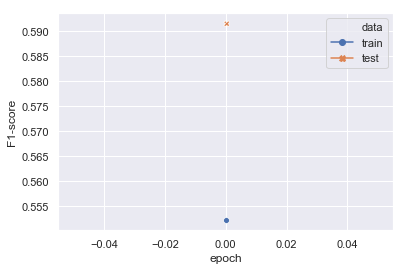

In [188]:
import seaborn as sns
sns.set()
ax = sns.lineplot(x="epoch", y="F1-score",
                   hue="data", style="data",
                   markers=True, dashes=False, data=epochs_f1_scores)
plt.show()

In [ ]:
sentence_lens = [len(sent) for sent in sentences]

Sentence lengths


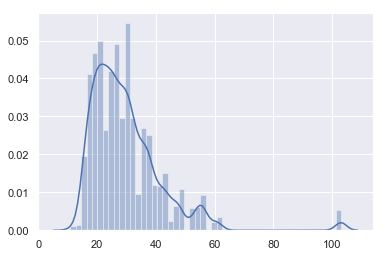

In [105]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set()
ax = sns.distplot(sentence_lens)
print('Sentence lengths')
plt.show()

In [453]:
figure = ax.get_figure()
figure.savefig('../plots/dl/sentence_length_dist.pdf')

In [196]:
len(metrics.f1_scores)

2

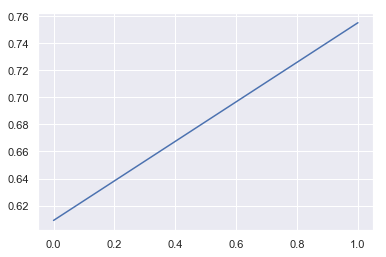

In [197]:
sns.set_style("darkgrid")
epoch_f1s = plt.plot(metrics.f1_scores)
plt.show()